In [1974]:
import numpy as np
import math 
import matplotlib.pyplot as plt
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

In [1975]:
data_orig = np.genfromtxt('data/housepricedata.csv',delimiter=',',skip_header=1)
print("Dataset : \n\n"+ str(data_orig))
print("\nDimensions of dataset : "+str(data_orig.shape))

Dataset : 

[[8.450e+03 7.000e+00 5.000e+00 ... 0.000e+00 5.480e+02 1.000e+00]
 [9.600e+03 6.000e+00 8.000e+00 ... 1.000e+00 4.600e+02 1.000e+00]
 [1.125e+04 7.000e+00 5.000e+00 ... 1.000e+00 6.080e+02 1.000e+00]
 ...
 [9.042e+03 7.000e+00 9.000e+00 ... 2.000e+00 2.520e+02 1.000e+00]
 [9.717e+03 5.000e+00 6.000e+00 ... 0.000e+00 2.400e+02 0.000e+00]
 [9.937e+03 5.000e+00 6.000e+00 ... 0.000e+00 2.760e+02 0.000e+00]]

Dimensions of dataset : (1460, 11)


In [1976]:
#Seed for np.random
seed=9
np.random.seed(seed)

In [1977]:
#Shuffling imported original dataset
np.random.shuffle(data_orig)

In [1978]:
#Shuffled dataset
print("Shuffled dataset with (Seed "+str(seed) +") :\n\n"+str(data_orig))
print("\n"+str(data_orig.shape))

Shuffled dataset with (Seed 9) :

[[3.9640e+03 6.0000e+00 4.0000e+00 ... 1.0000e+00 5.7600e+02 0.0000e+00]
 [3.9104e+04 7.0000e+00 7.0000e+00 ... 2.0000e+00 4.3900e+02 1.0000e+00]
 [6.0400e+03 4.0000e+00 5.0000e+00 ... 0.0000e+00 0.0000e+00 0.0000e+00]
 ...
 [8.7770e+03 5.0000e+00 7.0000e+00 ... 0.0000e+00 0.0000e+00 0.0000e+00]
 [2.4480e+03 7.0000e+00 5.0000e+00 ... 0.0000e+00 4.7400e+02 0.0000e+00]
 [9.2450e+03 7.0000e+00 5.0000e+00 ... 0.0000e+00 6.3900e+02 1.0000e+00]]

(1460, 11)


In [1979]:
#Extacting Y
y_orig = data_orig[:,-1]
print("Output Y   :"+str(y_orig))
print("Shape of Y : "+str(y_orig.shape))

Output Y   :[0. 1. 0. ... 0. 0. 1.]
Shape of Y : (1460,)


In [1980]:
Y = np.reshape(y_orig,(y_orig.shape[0],1)).T    
print("Shape of Y: "+ str(Y.shape))

Shape of Y: (1, 1460)


In [1981]:
#Extracting vectorized input feature X (transposed)
x_shuffled = data_orig[:,0:-1].T
print("Input set : \n\n" +str(x_shuffled))

Input set : 

[[3.9640e+03 3.9104e+04 6.0400e+03 ... 8.7770e+03 2.4480e+03 9.2450e+03]
 [6.0000e+00 7.0000e+00 4.0000e+00 ... 5.0000e+00 7.0000e+00 7.0000e+00]
 [4.0000e+00 7.0000e+00 5.0000e+00 ... 7.0000e+00 5.0000e+00 5.0000e+00]
 ...
 [1.0000e+01 5.0000e+00 6.0000e+00 ... 4.0000e+00 6.0000e+00 8.0000e+00]
 [1.0000e+00 2.0000e+00 0.0000e+00 ... 0.0000e+00 0.0000e+00 0.0000e+00]
 [5.7600e+02 4.3900e+02 0.0000e+00 ... 0.0000e+00 4.7400e+02 6.3900e+02]]


In [1982]:
print(x_shuffled.shape)
X=x_shuffled

(10, 1460)


In [1983]:
#Splitting into Train, Test sets ( with a fixed seed )
train_split_percent = 80
test_split_percent = 20

train_X , test_X = X[:, : int( (train_split_percent/100)*X.shape[1])] , X[:,int( (train_split_percent/100)*X.shape[1]) : ]
train_Y , test_Y = Y[:, : int( (train_split_percent/100)*X.shape[1])] , Y[:,int( (train_split_percent/100)*X.shape[1]) : ]
print("Seed of Randomization   : "+str(seed))
print("\nShape of Training set X : "+str(train_X.shape))
print("Shape of Training set Y : "+str(train_Y.shape))
print("\nShape of Test set   X   : "+str(test_X.shape))
print("Shape of Test set Y     : "+str(test_Y.shape))

Seed of Randomization   : 9

Shape of Training set X : (10, 1168)
Shape of Training set Y : (1, 1168)

Shape of Test set   X   : (10, 292)
Shape of Test set Y     : (1, 292)


In [1984]:
m_train = train_X.shape[1]
m_test  = test_X.shape[1]
print("No of training examples : "+str(m_train))
print("No of test example      : "+str(m_test))

No of training examples : 1168
No of test example      : 292


In [1985]:
def standardize(x):
    """
    Input  :  Numpy array x 
    Output :  Numpy array of same shape as X but standardized along each rows
    
    """
    x_mean = np.mean(x,axis=1, keepdims=True)
    x_std = np.std(x, axis=1, keepdims=True)+0.0000001

    #print("Mean of each row : \n\n"+str(x_mean))
    #print("\nStandard deviation of each row : \n\n"+str(x_std))

    X = (x - x_mean)/x_std   #Python Broadcasting

    return X

In [1986]:
train_X = standardize(train_X)
print("Standardize train_X : "+str(train_X.shape)+"\n\n"+str(train_X))
test_X  = standardize(test_X)
print("\n\nStandardize test_X : "+str(test_X.shape)+"\n\n"+str(test_X))

Standardize train_X : (10, 1168)

[[-0.62294439  2.64369886 -0.42995773 ... -0.07112896  0.33101956
  -0.14224398]
 [-0.06530134  0.66109837 -1.51810077 ...  0.66109837  1.38749808
  -0.06530134]
 [-1.39247961  1.28548337 -0.49982528 ... -0.49982528 -0.49982528
  -0.49982528]
 ...
 [ 2.17516164 -0.92614304 -0.30588211 ...  1.5549007   1.5549007
   0.31437883]
 [ 0.59351649  2.15836359 -0.9713306  ...  0.59351649  0.59351649
  -0.9713306 ]
 [ 0.48109632 -0.16278512 -2.22602564 ...  0.85708548  1.9803531
   0.33070066]]


Standardize test_X : (10, 292)

[[-0.09938328  0.03686526 -0.32759958 ... -0.19526819 -1.27316445
  -0.11556279]
 [-1.52084774 -0.09749024 -0.09749024 ... -0.80916899  0.61418851
   0.61418851]
 [ 0.33665213 -0.59072921 -0.59072921 ...  1.26403347 -0.59072921
  -0.59072921]
 ...
 [-1.56607354  0.22958146  0.82813313 ... -1.56607354 -0.36897021
   0.82813313]
 [-0.87582323  0.62853197  0.62853197 ... -0.87582323 -0.87582323
  -0.87582323]
 [-1.08665717  0.03514285 -0.180

In [1987]:
def sigmoid(Z):
    sigz= 1/(1+np.exp(-Z))
    sigz[sigz==1] = 0.99999999999
    sigz[sigz==0] = 0.000000000001
    return sigz        

def relu(Z):
    return np.maximum(0,Z)

def sigmoid_backward(dA, Z):
    sig = sigmoid(Z)
    return dA * sig * (1 - sig)

def relu_backward(dA, Z):
    dZ = np.array(dA, copy = True)
    dZ[Z <= 0] = 0;
    return dZ;

In [1988]:
def initialize_parameters(n_x, n_h, n_y):
    
    W1 = np.random.randn(n_h,n_x)*0.1
    b1 = np.zeros((n_h,1))
    W2 = np.random.randn(n_y,n_h)*0.1
    b2 = np.zeros((n_y,1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters 

In [1989]:
def initialize_parameters_deep(layer_dims):
    parameters = {}
    L = len(layer_dims)            

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l],layer_dims[l-1])*(2/layer_dims[l-1])**0.5
        parameters['b' + str(l)] = np.zeros((layer_dims[l],1))
        
    return parameters

In [1990]:
def linear_forward(A, W, b):
   
    Z = np.dot(W,A)+b
    #Z = standardize(Z) Batch-Normalize with u,var=1
    cache = (A, W, b)
    
    return Z, cache

In [1991]:
def linear_activation_forward(A_prev, W, b, activation):
    
    
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev,W,b)
        A, activation_cache = sigmoid(Z), sigmoid(Z)
    
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev,W,b)
        A, activation_cache = relu(Z), relu(Z)
        dropout_cache = A
        D = np.random.rand(A.shape[0],A.shape[1])                                        
        D = (D < keep_prob).astype(int)                                         
        A = A*D                                         
        A = A/keep_prob 
        global Dcache 
        Dcache = D
    
    cache = (linear_cache, activation_cache,Dcache)

    return A, cache

In [2005]:
def forwardprop(X, parameters):

    caches = []
    D = []
    A = X
    L = len(parameters) // 2                
    
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters["W"+str(l)], parameters["b"+str(l)],"relu")
        caches.append(cache)
        
    AL, cache = linear_activation_forward(A, parameters["W"+str(L)], parameters["b"+str(L)],"sigmoid")
    caches.append(cache)
            
    return AL, caches

In [1993]:
def compute_cost(AL, Y):
    
    m = Y.shape[1]
    #print(AL)
    cost = (-1/m)*(np.sum(Y*np.log(AL)+(1-Y)*np.log(1-AL)))
    cost = np.squeeze(cost)     
   
    return cost

In [1994]:
def linear_backward(dZ, linear_cache,keep_prob):
    
    A_prev, W, b = linear_cache
    m = A_prev.shape[1]

    dW = (1/m)*np.dot(dZ,A_prev.T)
    db = (1/m)*np.sum(dZ,axis=1,keepdims=True)
    dA_prev = np.dot(W.T,dZ)
    
    return dA_prev, dW, db

In [1995]:
def linear_activation_backward(dA, cache, activation,keep_prob):

    linear_cache, activation_cache, dropout_cache = cache
    global dA_prev, dW, db
    if activation == "relu":
        dZ = relu_backward(dA,activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache,keep_prob)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA,activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache,keep_prob=1)
    
    return dA_prev, dW, db

In [1996]:
def update_parameters(parameters, grads, learning_rate):
    
    L = len(parameters) // 2 

    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l + 1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l + 1)]
        
    return parameters

In [1997]:
def initialize_adam(parameters) :

    L = len(parameters) // 2 
    v = {}
    s = {}
    
    for l in range(L):
        v["dW" + str(l+1)] = np.zeros((parameters["W" + str(l+1)].shape[0],parameters["W" + str(l+1)].shape[1]))
        v["db" + str(l+1)] = np.zeros((parameters["b" + str(l+1)].shape[0],parameters["b" + str(l+1)].shape[1]))
        s["dW" + str(l+1)] = np.zeros((parameters["W" + str(l+1)].shape[0],parameters["W" + str(l+1)].shape[1]))
        s["db" + str(l+1)] = np.zeros((parameters["b" + str(l+1)].shape[0],parameters["b" + str(l+1)].shape[1]))
   
    return v, s

In [1998]:
def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate = 0.01,
                                beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8):

    L = len(parameters) // 2                 
    v_corrected = {}                         
    s_corrected = {}                        
    
    # Perform Adam update on all parameters
    for l in range(L):
        v["dW" + str(l+1)] = beta1*v["dW" + str(l+1)]+(1-beta1)*grads['dW'+str(l+1)]
        v["db" + str(l+1)] = beta1*v["db" + str(l+1)]+(1-beta1)*grads['db'+str(l+1)]
       
        v_corrected["dW" + str(l+1)] = v["dW" + str(l+1)]/(1-pow(beta1,t)) 
        v_corrected["db" + str(l+1)] = v["db" + str(l+1)]/(1-pow(beta1,t))
        
        s["dW" + str(l+1)] = beta2*s["dW" + str(l+1)]+(1-beta2)*np.power(grads['dW'+str(l+1)],2)
        s["db" + str(l+1)] = beta2*s["db" + str(l+1)]+(1-beta2)*np.power(grads['db'+str(l+1)],2)

        s_corrected["dW" + str(l+1)] = s["dW" + str(l+1)]/(1-pow(beta2,t))
        s_corrected["db" + str(l+1)] = s["db" + str(l+1)]/(1-pow(beta2,t))

        parameters["W" + str(l+1)] = parameters["W" + str(l+1)]-learning_rate*np.divide(v_corrected["dW" + str(l+1)],np.sqrt(s_corrected["dW" + str(l+1)])+epsilon)
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)]-learning_rate*np.divide(v_corrected["db" + str(l+1)],np.sqrt(s_corrected["db" + str(l+1)])+epsilon)

    return parameters, v, s

In [1999]:
def model(X, Y, layers_dims, learning_rate = 0.003, num_iterations = 3000,
                  beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8, print_after=1):

    costs = []                      
    
    parameters = initialize_parameters_deep(layers_dims)
    v, s = initialize_adam(parameters)
    t = 10000000
    
    for i in range(0, num_iterations):
        AL, caches = forwardprop(X, parameters)
        cost = compute_cost(AL, Y)
        grads = backwardprop(AL, Y, caches)
        t = t + 0.1
        parameters, v, s = update_parameters_with_adam(parameters, grads, v, s,
                                                               t, learning_rate, beta1, beta2,  epsilon)
        if i % print_after == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if  i % print_after == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per '+str(print_after)+')')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

In [2000]:
def evaluate(Y,Yhat,Set):
    spos=0
    
    for i in range(Y.shape[1]): 
        if Y[0,i]==1 and Yhat[0,i]==1:
            spos = spos+1
            
    p = spos /np.sum(Yhat == 1)
    r = spos/ np.sum( Y == 1)
    acc = np.mean(Y == Yhat)
    f1score = 2*p*r/(p+r)
    
    #print(Set+" :       "+str(p) + "  "+str(r)+"  "+str(f1score)+"  "+str(acc))
    error = (1-acc)*100
    print(Set+" :       "+'%0.3f'%error+" %")
    
    return 

Cost after iteration 0: 0.858608
Cost after iteration 100: 0.449797
Cost after iteration 200: 0.275363
Cost after iteration 300: 0.223139
Cost after iteration 400: 0.206983


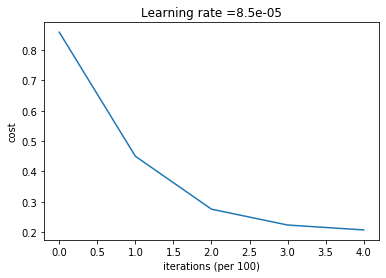

Train :       8.904 %
Test  :       10.959 %


In [2015]:
np.random.seed(seed)
global dropout_cache
global keep_prob
keep_prob=1
parameters = model(train_X, train_Y, layers_dims = [10,64,48,24,16,8,4,1], num_iterations =401, 
                           learning_rate = 0.000085,  beta1 = 0.92, beta2 = 0.9,  epsilon = 1e-8, 
                           print_after = 100)

def predict(X,parameters):
    
    AL = forwardprop(X, parameters)[0]
    Y_prediction = AL
    for i in range(AL.shape[1]):
          Y_prediction[0, i] = 1 if AL[0, i] > 0.5 else 0
   
    return Y_prediction 

test_Yhat = predict(test_X,parameters)
train_Yhat = predict(train_X,parameters)


#print("    "+" :       "+ "\t Precision " + "  "+ "     \tRecall" +"  "+"          F-score "+"  "+"         Accuracy")

evaluate(train_Y,train_Yhat,"Train")
evaluate(test_Y,test_Yhat,"Test ")



In [2002]:
def backwardprop(AL, Y, caches):
    grads = {}
    L = len(caches) 
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) 
    
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    #print(caches[-2][-1].shape)
    #print(L)
    
    current_cache = caches[-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache,"sigmoid",keep_prob=1)
    
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        global Dprev_cache
        D_prev = caches[l-1][2]
        global dA_prev_temp, dW_temp, db_temp
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache,
                                                                "relu",keep_prob)
        if l > 0:
            dA_prev_temp = np.multiply(dA_prev_temp,D_prev)
            dA_prev_temp = dA_prev_temp/keep_prob
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads